In [1]:

from tensorflow.keras.datasets import cifar10

In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [5]:
y_test.shape

(10000,)

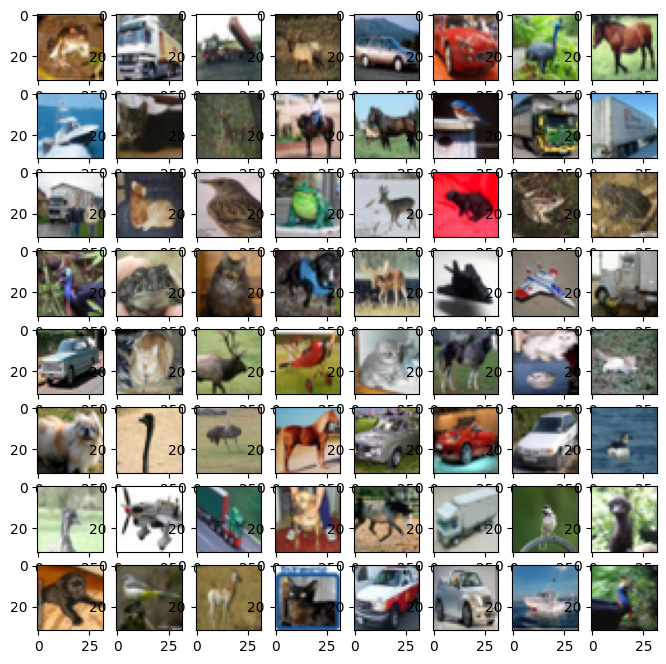

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(x_train[i], cmap = plt.cm.bone)
plt.show()

In [7]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [8]:
from skimage.feature import hog
from skimage.color import rgb2gray
from joblib import Parallel, delayed

def HogTransform(images):
    def hog_transform_single_image(im):
        gray_scale_image = rgb2gray(im)
        hog_transformed_image = hog(gray_scale_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        return hog_transformed_image
    hog_net = Parallel(n_jobs=-1)(delayed(hog_transform_single_image)(im) for im in images)
    
    return np.array(hog_net)

In [9]:
import numpy as np
x_train_hog = HogTransform(x_train)
x_test_hog = HogTransform(x_test)

In [10]:
x_train_hog.shape

(50000, 324)

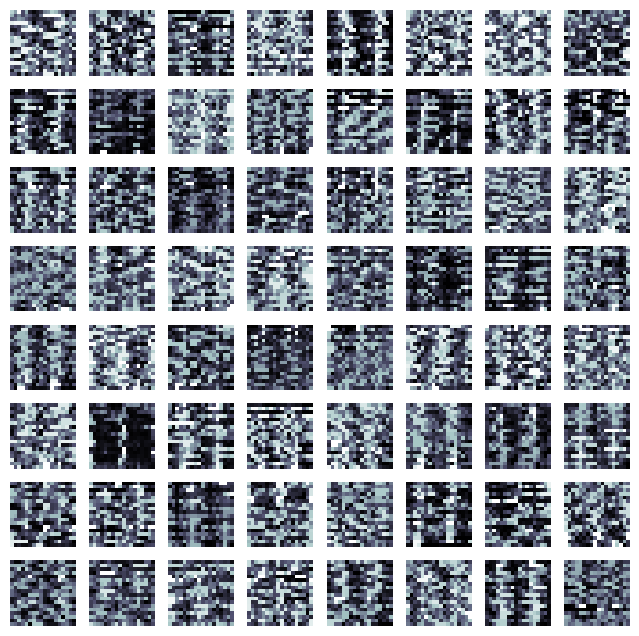

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(x_train_hog[i].reshape(18, 18), cmap = plt.cm.bone)
    ax.axis('off')
plt.show()

In [12]:
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [13]:
pca = PCA()
pca.fit(x_train_hog)

PCA()

In [20]:
k = 0
csum=0
total = pca.explained_variance_.sum()
while csum/total <0.9:
    csum +=pca.explained_variance_[k]
    k=k+1
k

96

In [21]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(k)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train_hog, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=96)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [22]:

dump(pipe, 'pipe.joblib')

['pipe.joblib']

In [23]:

pipe = load('pipe.joblib')

pipe.score(x_test_hog, y_test)

0.6297

In [24]:
y_pred = pipe.predict(x_test_hog)

In [25]:
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [26]:
y_pred_names=[]
for i in y_pred:
    y_pred_names.append(label_names[i])

In [29]:
arr = np.array(y_pred_names)

In [32]:
np.savetxt('Cifar_predictions.csv', arr, delimiter=',', fmt='%s')